In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".2"

import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy

import jax
import jax.numpy as jnp
from jax import jit, lax, grad, value_and_grad

from neuron import h
_ = h.load_file("stdlib.hoc")

from neurax.integrate import solve
from neurax.cell import Cell
from neurax.stimulus import Stimulus, step_current
from neurax.recording import Recording
from neurax.connection import Connection

--No graphics will be displayed.


In [3]:
device_str = "cpu"
jax.config.update('jax_platform_name', device_str)

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

device = cpus[0] if device_str == "cpu" else gpus[0]

# Solve

### Define model

In [4]:
num_cells = 6
nseg_per_branch = 4
num_branches = 15
ncomp = num_branches * nseg_per_branch
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])

assert len(parents) == num_branches
g_na = jnp.asarray([[0.12] * ncomp] * num_cells)
g_kd = jnp.asarray([[0.036] * ncomp] * num_cells)
g_leak = jnp.asarray([[0.0003] * ncomp] * num_cells)
params = jnp.stack([g_na, g_kd, g_leak])

init_v = jnp.asarray([[-62.0] *num_branches*nseg_per_branch] * num_cells)
init_m = jnp.asarray([[0.074901] *num_branches*nseg_per_branch] * num_cells)
init_h = jnp.asarray([[0.4889] *num_branches*nseg_per_branch] * num_cells)
init_n = jnp.asarray([[0.3644787] *num_branches*nseg_per_branch] * num_cells)
u = jnp.stack([init_v, init_m, init_h, init_n])

length = 100.0  # um (length of a single branch)
radius = 10.0  # um
r_a = 10_000  # ohm cm 
i_delay = 5.0  # ms
i_amp = 1.0  # nA
i_dur = 2.0  # ms
dt = 0.025  # ms
t_max = 1.0  # ms

### Set up model

In [5]:
time_vec = jnp.arange(0, t_max+dt, dt)

In [6]:
cells = [Cell(num_branches, parents, nseg_per_branch, length, radius, r_a)] * num_cells
stims = [
    Stimulus(cell_ind=0, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
    Stimulus(cell_ind=1, branch_ind=0, loc=0.0, current=step_current(i_delay, i_dur, i_amp, time_vec)),
]
recs = [
    Recording(0, 0, 0.0),
    Recording(0, 6, 1.0),
    Recording(1, 0, 0.0),
    Recording(1, 6, 1.0),
    Recording(3, 0, 0.0),
    Recording(3, 6, 1.0),
    Recording(4, 0, 0.0),
    Recording(4, 6, 1.0),
]
conns = [
    Connection(0, 0, 0.0, 3, 0, 0.0),
    Connection(1, 0, 0.0, 3, 0, 0.3),
]

### Run solver

In [7]:
start_time = time.time()

In [10]:
s = solve(cells, u, params, jnp.ones((2,)), stims, recs, conns, t_max=t_max, dt=dt, solver="stone")

In [12]:
s

Array([[-62.      , -62.108852, -62.215157, -62.319168, -62.421112,
        -62.521175, -62.619545, -62.716362, -62.811764, -62.90584 ,
        -62.9987  , -63.090416, -63.18105 , -63.270638, -63.35924 ,
        -63.44688 , -63.53357 , -63.619335, -63.704193, -63.788143,
        -63.871197, -63.95333 , -64.03456 , -64.11488 , -64.194275,
        -64.27273 , -64.350235, -64.4268  , -64.502396, -64.57702 ,
        -64.65065 , -64.72329 , -64.794914, -64.86551 , -64.93508 ,
        -65.003624, -65.07111 , -65.13754 , -65.20293 , -65.26725 ,
        -65.33049 ],
       [-62.      , -62.108856, -62.215164, -62.31917 , -62.42112 ,
        -62.521194, -62.619556, -62.71638 , -62.811775, -62.905865,
        -62.998734, -63.09044 , -63.18107 , -63.270668, -63.35927 ,
        -63.446907, -63.533604, -63.619373, -63.704235, -63.788193,
        -63.871254, -63.953396, -64.034615, -64.11493 , -64.19431 ,
        -64.27277 , -64.35029 , -64.42686 , -64.50245 , -64.577065,
        -64.650696, -64.723

In [ ]:
print("Time: ", time.time() - start_time)

### Vis

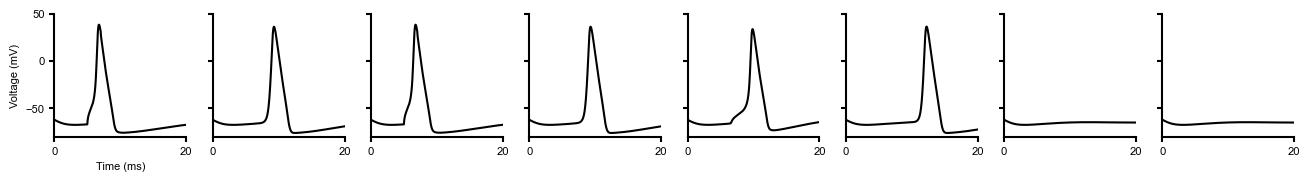

In [44]:
num_recs = 8
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, num_recs, figsize=(num_recs * 2, 1.6))
    ax = np.atleast_1d(ax)
    for i in range(num_recs):
        _ = ax[i].plot(time_vec, s[i], c="k")

    _ = ax[0].set_xlabel("Time (ms)")
    _ = ax[0].set_ylabel("Voltage (mV)")
    
    for a in ax[1:]:
        a.set_yticklabels([])
    for a in ax:
        _ = a.set_ylim([-80, 50])
        a.set_xticks([0, t_max])
        a.set_xlim([0, t_max])
    plt.show()

# Gradient

In [52]:
checkpoint_inds = [200, 400, 600]
def sum_ode(diff_params):
    s = solve_and_grad(cells, u, diff_params, stims, recs, conns, t_max=t_max, dt=dt, solver="stone", checkpoint_inds=checkpoint_inds)
    return jnp.mean(s)

In [53]:
jitted_sum_ode = jit(sum_ode)

In [55]:
start_time = time.time()
result = jitted_sum_ode(params)
print("Time:  ", time.time() - start_time)

Time:   0.22594618797302246


In [66]:
jitted_grad = jit(value_and_grad(sum_ode))

In [67]:
start_time = time.time()
result = jitted_grad(params)
print("Time:  ", time.time() - start_time)
print("Solve", result[0])
print("Grad", result[1][:, 0, ::100])

Time:   125.0822319984436
Solve -61.26784
Grad [[-1.8830334e-03  6.6960134e-02 -4.4424207e-05]
 [-9.2289299e-02 -4.3984312e-01 -3.4559614e-03]
 [ 1.1711740e+01  2.0708889e+01  3.9166570e-01]]


### Check vs finit differences

In [106]:
all_finite_diffs = []
all_auto_diffs = []
epsilon = 5e-3
for cond_ind in [0, 1, 2]:
    all_finite_diffs_for_cond = []
    all_auto_diffs_for_cond = []
    for cell_ind in [0, 1, 3, 4]:
        for comp_ind in [0, 40, 80, 120, 160, 200]:
            params_lower = deepcopy(params)
            params_upper = deepcopy(params)
            params_lower = params_lower.at[cond_ind, cell_ind, comp_ind].add(-epsilon / 2)
            params_upper = params_upper.at[cond_ind, cell_ind, comp_ind].add(epsilon / 2)
            finite_diff_grad = (sum_ode(params_upper) - sum_ode(params_lower)) / epsilon
#             print(f"cond: {cond_ind}, cell: {cell_ind}, comp: {comp_ind}, finite / auto {1000*finite_diff_grad:.4f}, {1000*result[1][cond_ind, cell_ind, comp_ind]:.4f}")
            all_finite_diffs_for_cond.append(finite_diff_grad)
            all_auto_diffs_for_cond.append(result[1][cond_ind, cell_ind, comp_ind])
    all_finite_diffs.append(all_finite_diffs_for_cond)
    all_auto_diffs.append(all_auto_diffs_for_cond)
            

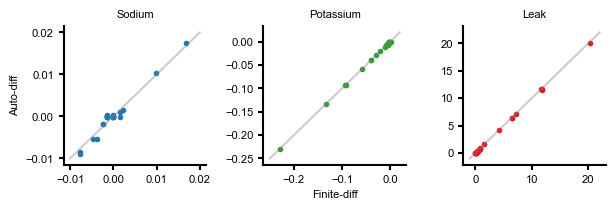

In [129]:
with mpl.rc_context(fname=".matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(7, 1.8))
    ax[0].plot([-0.01, 0.02], [-0.01, 0.02], c="gray", alpha=0.4)
    ax[1].plot([-0.25, 0.02], [-0.25, 0.02], c="gray", alpha=0.4)
    ax[2].plot([-1, 22], [-1, 22], c="gray", alpha=0.4)
    ax[0].scatter(all_finite_diffs[0], all_auto_diffs[0], c="#1f78b4")
    ax[1].scatter(all_finite_diffs[1], all_auto_diffs[1], c="#33a02c")
    ax[2].scatter(all_finite_diffs[2], all_auto_diffs[2], c="#e31a1c")
    ax[0].set_title("Sodium")
    ax[1].set_title("Potassium")
    ax[2].set_title("Leak")
    ax[0].set_ylabel("Auto-diff")
    ax[1].set_xlabel("Finite-diff")
    plt.subplots_adjust(wspace=0.4)
    plt.savefig("../../results/finite_vs_auto.png", dpi=200, bbox_inches="tight")
    plt.show()